## Capstone Project - The Battel Of Neighborhoods


installing required dependencies

In [2]:
!pip install geocoder
!pip install folium

import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

     |████████████████████████████████| 98 kB 7.8 MB/s  eta 0:00:01
     |████████████████████████████████| 94 kB 5.4 MB/s  eta 0:00:01


## Data Extraction

In [5]:
pulled_data = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
wiki_data = BeautifulSoup(pulled_data, 'lxml')
wiki_data

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of postal codes of Canada: M - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"YCDXKApAAMEAAr5tYjkAAABQ","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":1004901187,"wgRevisionId":1004901187,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Short description is different from Wikidata","Communications in Ontario","Postal code

In [7]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)
toronto

,Postalcode,Borough,Neighborhood
0,0,0,0
1,M1A\n,Not assigned\n,Not assigned
2,M2A\n,Not assigned\n,Not assigned
3,M3A\n,North York\n,Parkwoods
4,M4A\n,North York\n,Victoria Village
...,...,...,...
176,M5Z\n,Not assigned\n,Not assigned
177,M6Z\n,Not assigned\n,Not assigned
178,M7Z\n,Not assigned\n,Not assigned
179,M8Z\n,Etobicoke\n,"Mimico NW, The Queensway West, South of Bloor,..."


In [9]:
# removing non required data
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1
toronto

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods
3,M4A\n,North York\n,Victoria Village
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z\n,Not assigned\n,Not assigned\n
176,M6Z\n,Not assigned\n,Not assigned\n
177,M7Z\n,Not assigned\n,Not assigned\n
178,M8Z\n,Etobicoke\n,"Mimico NW, The Queensway West, South of Bloor,..."


,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M1B,Scarborough,"Malvern, Rouge"
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn
...,...,...,...
175,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."
176,M9W,Etobicoke,"Northwest, West Humber - Clairville"
177,M9X,Not assigned,Not assigned
178,M9Y,Not assigned,Not assigned


In [22]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df = df.dropna()
df = df.replace('\n','', regex=True)
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]
df.head()


,Postalcode,Borough,Neighborhood
1,M1B,Scarborough,"Malvern, Rouge"
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn
5,M1H,Scarborough,Cedarbrae


In [25]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
ng_group = df.groupby(['Postalcode', 'Borough'])
ng_df = ng_group.apply(neighborhood_list).reset_index(name='Neighborhood')
ng_df

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [31]:
def get_cords(postal_code):
    cords = None
    while(cords is None):
        g = geocoder.arcgis(f'{postal_code}, Toronto, Ontario')
        cords = g.latlng
    return cords

In [32]:
postal_codes = ng_df['Postalcode']    
cords = [ get_cords(postal_code) for postal_code in postal_codes.tolist()]
cords

[[43.811390000000074, -79.19661999999994],
 [43.78574000000003, -79.15874999999994],
 [43.765750000000025, -79.17469999999997],
 [43.76812000000007, -79.21760999999998],
 [43.76944000000003, -79.23891999999995],
 [43.74446000000006, -79.23116999999996],
 [43.725820000000056, -79.26460999999995],
 [43.71289000000007, -79.28505999999999],
 [43.72360000000003, -79.23495999999994],
 [43.695100000000025, -79.26465999999994],
 [43.75998000000004, -79.26939999999996],
 [43.75075000000004, -79.30053999999996],
 [43.794520000000034, -79.26707999999996],
 [43.784910000000025, -79.29721999999998],
 [43.817810000000065, -79.28043999999994],
 [43.80079000000006, -79.32161999999994],
 [43.83412000000004, -79.21667999999994],
 [43.80225000000007, -79.35557999999997],
 [43.780970000000025, -79.34780999999998],
 [43.781120000000044, -79.38059999999996],
 [43.756980000000055, -79.38059999999996],
 [43.79182000000003, -79.41371999999996],
 [43.76774000000006, -79.40727999999996],
 [43.747780000000034, -7

In [34]:
# Add latitiude and logitude to aur dataframe as Column

cords = pd.DataFrame(cords, columns=['Latitude', 'Longitude'])
ng_df['Latitude'] = cords['Latitude']
ng_df['Longitude'] = cords['Longitude']
ng_df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G,Scarborough,Woburn,43.76812,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892


In [39]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="the-battel-of-neighbouhood")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude

scarborough_map = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(ng_df['Latitude'], ng_df['Longitude'], ng_df['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(scarborough_map)  
    
scarborough_map

In [42]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="the-battel-of-neighbouhood")
location = geolocator.geocode(address)
latitude_x1 = location.latitude
longitude_y1 = location.longitude

CLIENT_ID = 'I5T3MXLIVWWU22BUVBOUESFJHVFCO51SCRQ0TADP2EOJUVIZ' # my Foursquare ID
CLIENT_SECRET = 'RUNDH52ITMRWWEWFH30TP14RCYWJW4AHPCRC4S2LGRONNSKR' # my Foursquare Secret
VERSION = '20180604'
#LIMIT = 30

radius = 700 
LIMIT = 100
url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={latitude_x1},{longitude_y1}&radius={radius}&limit={LIMIT}'
results = requests.get(url).json()

venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [43]:
def get_category_type(row):
    
    cat_list = row['venue.categories']
        
    if len(cat_list) == 0:
        return None
    else:
        return cat_list[0]['name']

In [44]:
# Filtering out columns 

f_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, f_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
2,Coliseum Scarborough Cinemas,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",43.775995,-79.255649
3,Tommy Hilfiger,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369
4,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334


In [45]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,SEPHORA,Cosmetics Shop,43.775017,-79.258109
2,Coliseum Scarborough Cinemas,Movie Theater,43.775995,-79.255649
3,Tommy Hilfiger,Clothing Store,43.776015,-79.257369
4,American Eagle Store,Clothing Store,43.776012,-79.258334


In [47]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={radius}&limit={LIMIT}'
        
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']) for venue in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [49]:
scarborough_nearby_venues = getNearbyVenues(names=ng_df['Neighborhood'],
                                   latitudes=ng_df['Latitude'],
                                   longitudes=ng_df['Longitude']
                                  )
scarborough_nearby_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.81139,-79.19662,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern, Rouge",43.81139,-79.19662,Ecopainting inc.,43.808417,-79.202392,Construction & Landscaping
2,"Malvern, Rouge",43.81139,-79.19662,AMJ Painting,43.815430,-79.201839,Construction & Landscaping
3,"Malvern, Rouge",43.81139,-79.19662,Grizzly Bear Exhibit,43.817031,-79.193458,Zoo Exhibit
4,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875,Great Shine Window Cleaning,43.783145,-79.157431,Home Service
...,...,...,...,...,...,...,...
3557,"Northwest, West Humber - Clairville",43.71174,-79.57941,Rexdale Hyundai,43.713733,-79.578123,Auto Dealership
3558,"Northwest, West Humber - Clairville",43.71174,-79.57941,Fitness Two 4,43.714482,-79.582903,Gym
3559,"Northwest, West Humber - Clairville",43.71174,-79.57941,Ali Baba's Middle Eastern Cuisine,43.711704,-79.573288,Middle Eastern Restaurant
3560,"Northwest, West Humber - Clairville",43.71174,-79.57941,FREEWAY AUTO SERVICE & TOWING,43.716775,-79.582030,Auto Garage


In [52]:
scarborough_nearby_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,23,23,23,23,23,23
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",14,14,14,14,14,14
Bayview Village,6,6,6,6,6,6
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25


### Features One Hot Encoding

In [53]:
scarborough_ohe = pd.get_dummies(scarborough_nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
scarborough_ohe['Neighborhood'] = scarborough_nearby_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [scarborough_ohe.columns[-1]] + list(scarborough_ohe.columns[:-1])
scarborough_ohe = scarborough_ohe[fixed_columns]
scarborough_group = scarborough_ohe.groupby('Neighborhood').mean().reset_index()
scarborough_ohe.head(5)

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
top_venues = 5
for ng in scarborough_group['Neighborhood']:
    temp =scarborough_group[scarborough_group['Neighborhood'] == ng].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(top_venues))
    print('\n')

                venue  freq
0       Shopping Mall  0.09
1  Chinese Restaurant  0.09
2      Breakfast Spot  0.04
3         Coffee Shop  0.04
4          Print Shop  0.04


         venue  freq
0   Print Shop  0.14
1  Coffee Shop  0.14
2  Gas Station  0.14
3     Pharmacy  0.14
4          Gym  0.14


                      venue  freq
0               Coffee Shop  0.14
1               Pizza Place  0.14
2  Mediterranean Restaurant  0.07
3       Fried Chicken Joint  0.07
4         Mobile Phone Shop  0.07


              venue  freq
0              Park  0.17
1  Asian Restaurant  0.17
2       Gas Station  0.17
3           Dog Run  0.17
4             Trail  0.17


                venue  freq
0         Coffee Shop  0.08
1  Italian Restaurant  0.08
2      Sandwich Place  0.08
3     Thai Restaurant  0.04
4           Juice Bar  0.04


                 venue  freq
0          Coffee Shop  0.09
1                Hotel  0.05
2  Japanese Restaurant  0.05
3                 Café  0.04
4         Cocktail Bar 

                venue  freq
0                 Bar  0.08
1          Restaurant  0.05
2                Café  0.04
3        Cocktail Bar  0.04
4  Italian Restaurant  0.04


                           venue  freq
0     Construction & Landscaping  0.50
1                    Zoo Exhibit  0.25
2           Fast Food Restaurant  0.25
3                      Nightclub  0.00
4  Paper / Office Supplies Store  0.00


              venue  freq
0      Intersection   0.2
1  Sushi Restaurant   0.2
2        Playground   0.2
3          Pharmacy   0.2
4    Sandwich Place   0.2


           venue  freq
0  Burrito Place  0.12
1   Optical Shop  0.08
2           Bank  0.08
3    Yoga Studio  0.04
4            Gym  0.04


             venue  freq
0             Park  0.33
1  Thai Restaurant  0.17
2     Tennis Court  0.17
3    Grocery Store  0.17
4              Gym  0.17


               venue  freq
0       Skating Rink  0.25
1  Convenience Store  0.25
2      Grocery Store  0.25
3               Park  0.25
4        

In [76]:
def top_common_venues(row, top_venues):
    row_cat = row.iloc[1:]
    row_cat_sorted = row_cat.sort_values(ascending=False)
    
    return row_cat_sorted.index.values[0:top_venues]

In [77]:
import numpy as np
top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

ng_venues_sorted = pd.DataFrame(columns=columns)
ng_venues_sorted['Neighborhood'] = scarborough_group['Neighborhood']

for ind in np.arange(scarborough_group.shape[0]):
    ng_venues_sorted.iloc[ind, 1:] = top_common_venues(scarborough_group.iloc[ind, :], top_venues)

ng_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Pharmacy,Bubble Tea Shop,Skating Rink,Latin American Restaurant,Supermarket,Sushi Restaurant,Café,Sandwich Place
1,"Alderwood, Long Branch",Print Shop,Coffee Shop,Pharmacy,Pizza Place,Gym,Gas Station,Pub,Dumpling Restaurant,Discount Store,Distribution Center
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Pizza Place,Mediterranean Restaurant,Intersection,Middle Eastern Restaurant,Mobile Phone Shop,Deli / Bodega,Restaurant,Sandwich Place,Fried Chicken Joint
3,Bayview Village,Park,Flower Shop,Dog Run,Trail,Asian Restaurant,Gas Station,Yoga Studio,Donut Shop,Distribution Center,Dive Bar
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Comfort Food Restaurant,Juice Bar,Thai Restaurant,Sports Club,Intersection,Restaurant,Indian Restaurant


### K-means Cluster
##### After encoding and finding most common neighburhoods will apply Kmeans to find clusters

In [78]:
scarborough_cluster = scarborough_group.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(scarborough_cluster)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 2], dtype=int32)

In [79]:
ng_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
scarborough_merged =ng_df.iloc[:16,:]
scarborough_merged = scarborough_merged.join(ng_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
scarborough_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662,1,Construction & Landscaping,Zoo Exhibit,Fast Food Restaurant,Electronics Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875,1,Home Service,Bar,Moving Target,Fish & Chips Shop,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470,0,Park,Gymnastics Gym,Athletics & Sports,Gym / Fitness Center,Farm,Dumpling Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
3,M1G,Scarborough,Woburn,43.76812,-79.21761,0,Park,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Eastern European Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892,1,Gas Station,Bakery,Caribbean Restaurant,Bank,Hakka Restaurant,Athletics & Sports,Thai Restaurant,Dumpling Restaurant,Dive Bar,Dog Run


In [92]:
k_clusters = 5

map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

x = np.arange(k_clusters)
colors_array = cm.rainbow(np.linspace(0, 1, k_clusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, nei , cluster in zip(scarborough_merged['Latitude'], 
                                   scarborough_merged['Longitude'], 
                                   scarborough_merged['Neighborhood'], 
                                   scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [93]:
df1=scarborough_merged.loc[scarborough_merged['Cluster Labels'] == 0,scarborough_merged.columns[[2] + list(range(5, scarborough_merged.shape[1]))]]
df2=scarborough_merged.loc[scarborough_merged['Cluster Labels'] == 1,scarborough_merged.columns[[2] + list(range(5, scarborough_merged.shape[1]))]]
df3=scarborough_merged.loc[scarborough_merged['Cluster Labels'] == 2,scarborough_merged.columns[[2] + list(range(5, scarborough_merged.shape[1]))]]

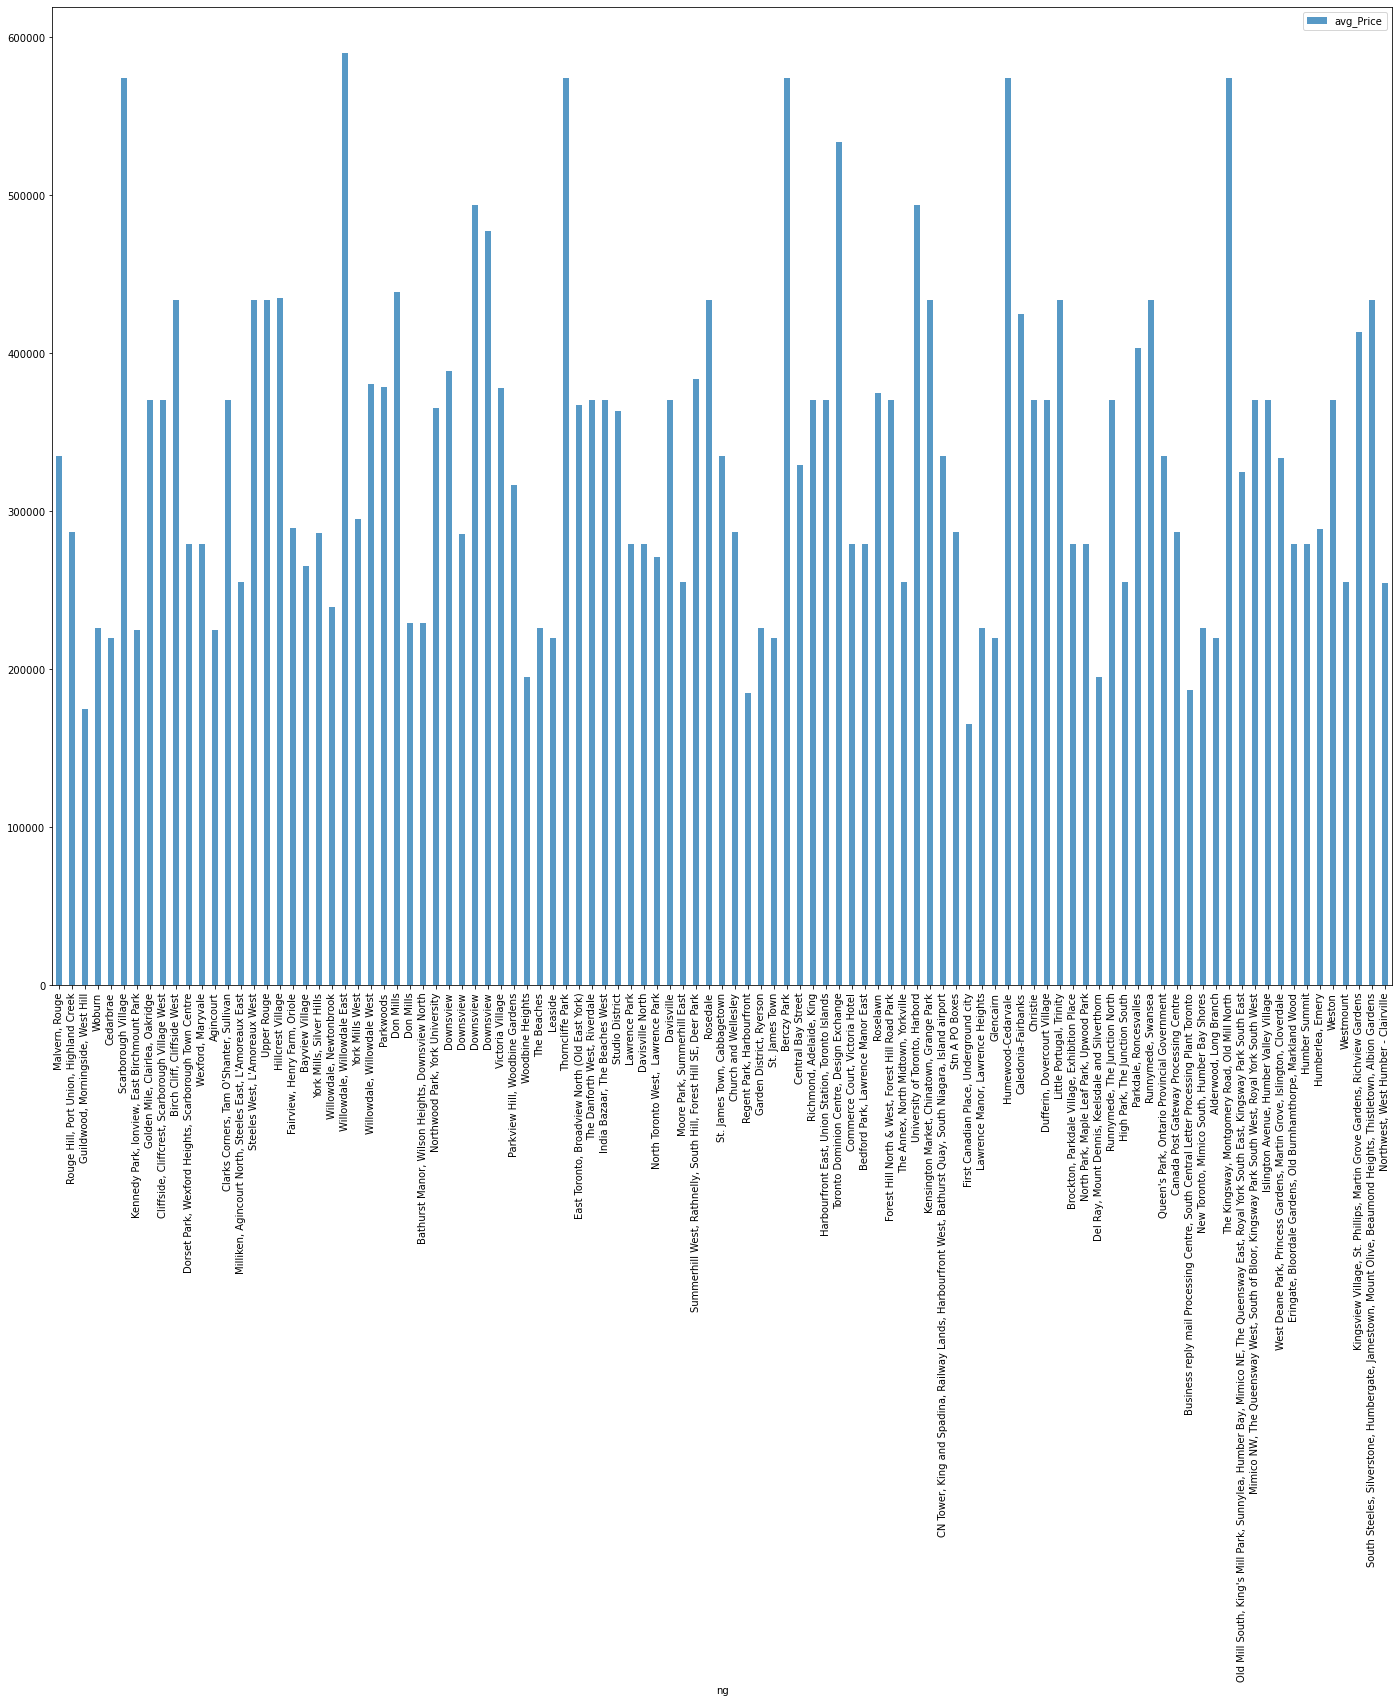

In [94]:
scarborough_avg_housingPrice=pd.DataFrame({"ng":ng_df["Neighborhood"],
                                      "avg_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})
scarborough_avg_housingPrice.set_index('ng',inplace=True,drop=True)
scarborough_avg_housingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

### School Rating

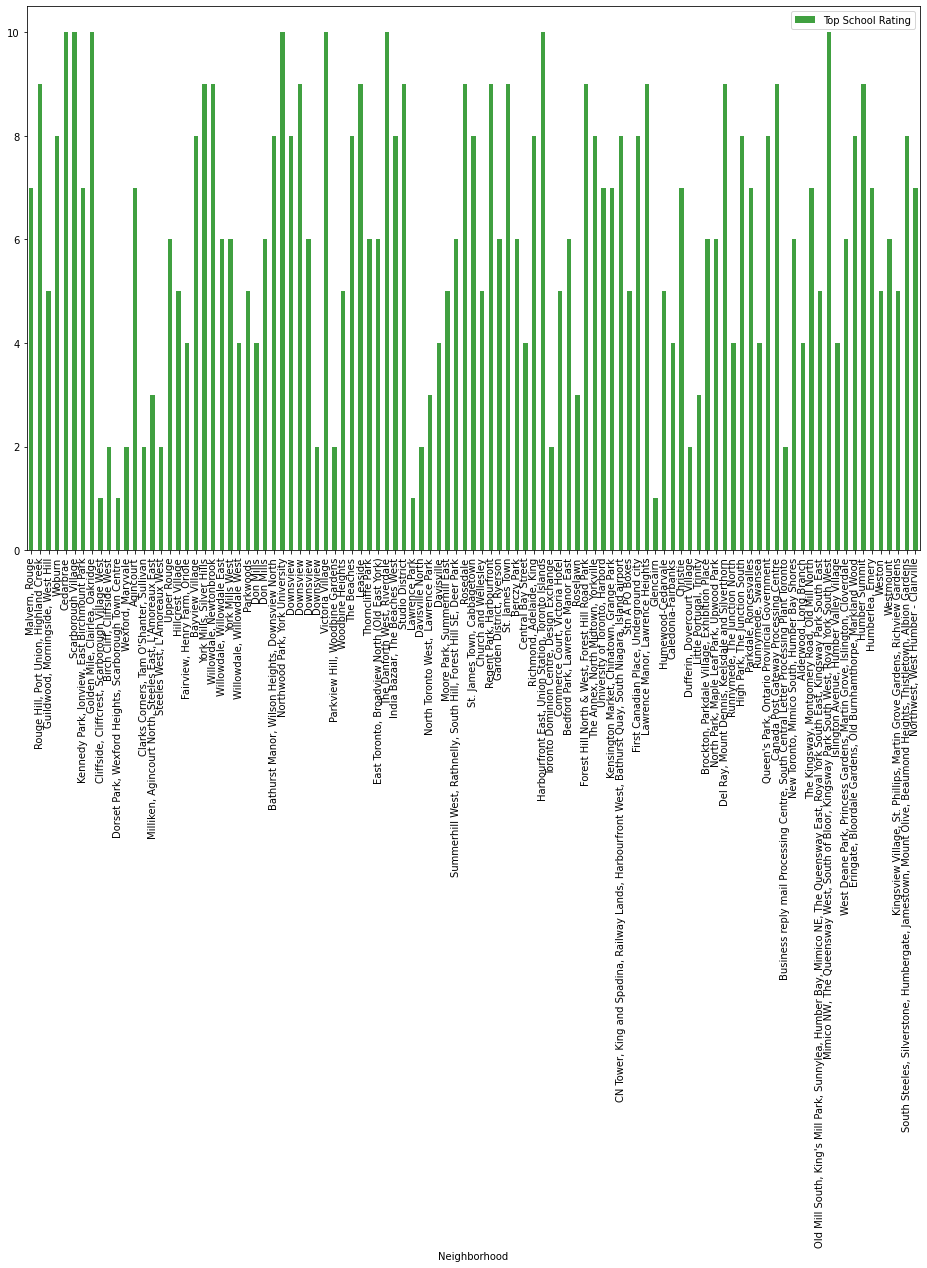

In [95]:
cluster=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
cluster = cluster.replace(np.nan, '', regex=True)
updated_scarborough=scarborough_merged.set_index("Neighborhood",drop=True)
school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})
school_ratings.set_index('Neighborhood',inplace=True,drop=True)
school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

Conclusion: By looking at above bar graphs we can see Scarborough Popular neighburhoods based on Housing Price and School Rating, that will help new migrant people to decide where to live. 
Using K-means I seperated neighburhood into 5 different clusters with 103 different lattitude and logitude from dataset which have similar neighborhoods around them.